In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import netCDF4 as nc
import datetime as dt
from salishsea_tools import evaltools as et, viz_tools, places
import gsw
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import matplotlib.dates as mdates
import cmocean
import h5py
#import scipy.io as so

mpl.rc('xtick', labelsize=8)
mpl.rc('ytick', labelsize=8)
mpl.rc('legend', fontsize=8)
mpl.rc('axes', titlesize=8)
mpl.rc('axes', labelsize=8)
mpl.rc('figure', titlesize=8)
mpl.rc('font', size=8)
mpl.rc('text', usetex=True)
mpl.rc('text.latex', preamble = r'''
 \usepackage{txfonts}
 \usepackage{lmodern}
 ''')
mpl.rc('font', family='sans-serif', weight='normal', style='normal')
%matplotlib inline

/home/eolson/anaconda3/envs/python36/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
chlToN=1.6

In [3]:
# load Sentry Shoal Nitrate
filepathN = '/ocean/eolson/MEOPAR/obs/Hakai/SentryShoal/Full_SUNA_Processed.mat'

arrays = {}
fSSN = h5py.File(filepathN)
for k, v in fSSN.items():
    arrays[k] = np.array(v)
ssdates = arrays['Full_SUNA_Processed'][0,:]
sstimes = arrays['Full_SUNA_Processed'][1,:]
sstemps = arrays['Full_SUNA_Processed'][2,:]
sssals = arrays['Full_SUNA_Processed'][3,:]
ssnitrate = arrays['Full_SUNA_Processed'][5,:]
ssdatenumber = arrays['Full_SUNA_Processed'][-1, :]
ssbase = dt.datetime(2000, 1, 1)
py_times = np.array([ssbase for i in range(63721)])
for n in range(63721):
    py_times[n] = ((dt.datetime.fromordinal(int(ssdatenumber[n])))
                       + dt.timedelta(days=ssdatenumber[n]%1)
                       - dt.timedelta(days = 366))
ssn = np.ma.masked_invalid(ssnitrate)


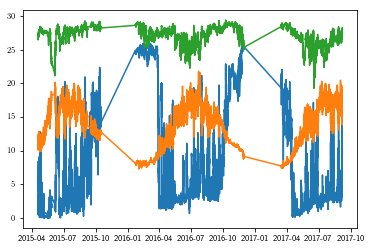

In [4]:
plt.plot(py_times,ssnitrate)
plt.plot(py_times,sstemps)
plt.plot(py_times,sssals)

In [5]:
data=pd.DataFrame({'dtUTC':py_times,
                  'tem':sstemps,
                  'sal':sssals,
                  'N':ssnitrate})

In [6]:
sslon,sslat=places.PLACES['Sentry Shoal']['lon lat']

In [7]:
p=gsw.p_from_z(1.0,sslat)
data['SA']=gsw.SA_from_SP(data['sal'],p,sslon,sslat)

In [8]:
data['CT']=gsw.CT_from_t(data['SA'],data['tem'],p)

In [9]:
data.head()

,dtUTC,tem,sal,N,SA,CT
0,2015-04-18 08:00:21.000000,11.48,26.57,NaN,26.698828,11.637182
1,2015-04-18 08:00:22.999999,11.48,26.57,NaN,26.698828,11.637182
2,2015-04-18 08:00:24.000004,11.48,26.57,NaN,26.698828,11.637182
3,2015-04-18 08:30:21.000003,11.48,26.57,NaN,26.698828,11.637182
4,2015-04-18 08:30:23.000003,11.48,26.57,NaN,26.698828,11.637182


In [10]:
dirs={2015:{'Bio':'hindcast2015','Phys':'hindcast2015P'},
     2016:{'Bio':'hindcast2016','Phys':'hindcast2016P'},
     2017:{'Bio':'hindcast2017','Phys':'hindcast2017P'},}
varNameDict={'Halibut Bank':'HalibutBank','Sentry Shoal':'SentryShoal', 'S3':'S3', 'Central node':'CentralNode', 'Central SJDF':'CentralSJDF'}
with open('/ocean/eolson/MEOPAR/analysis-elise/notebooks/bioTuning/spathsMaster.txt') as f:
    spaths = dict(x.strip().split() for x in f)
ff=dict()
ffp=dict()
pl='Sentry Shoal'
for iyr in (2015,2016,2017):
    ff[iyr]=nc.Dataset(spaths[dirs[iyr]['Bio']]+'ts_'+dirs[iyr]['Bio']+'_'+varNameDict[pl]+'.nc')
    ffp[iyr]=nc.Dataset(spaths[dirs[iyr]['Phys']]+'ts_'+dirs[iyr]['Phys']+'_'+varNameDict[pl]+'.nc')

In [11]:
data['l']=np.nan
data['mod_nitrate']=np.nan
data['mod_votemper']=np.nan
data['mod_vossaline']=np.nan

NEMOtime=np.array([(ii-dt.datetime(1900,1,1)).total_seconds() for ii in py_times])

for iyr in (2015,2016,2017):
    endtime=dt.datetime(1900,1,1)+dt.timedelta(seconds=ff[iyr].variables['time_centered_bounds'][-1,1])
    ii=(data['dtUTC'].dt.year==iyr)&(data['dtUTC']<endtime)
    data.loc[ii,['l']]=(np.digitize(NEMOtime[ii],ff[iyr].variables['time_centered_bounds'][:,0])-1).astype(int)
data.loc[data.l<0,['l']]=np.nan

for iyr in (2015,2016,2017):
    for il in np.unique(data.loc[ii&(data['l']>=0),['l']].astype(int)):
        data.loc[(data['dtUTC'].dt.year==iyr)&(data['l']==il),'mod_nitrate']=np.mean(ff[iyr].variables['nitrate'][il,:2,0,0])
        data.loc[(data['dtUTC'].dt.year==iyr)&(data['l']==il),'mod_votemper']=np.mean(ffp[iyr].variables['votemper'][il,:2,0,0])
        data.loc[(data['dtUTC'].dt.year==iyr)&(data['l']==il),'mod_vosaline']=np.mean(ffp[iyr].variables['vosaline'][il,:2,0,0])

In [13]:
times=dict()
for iyr in (2015,2016,2017):
    times[iyr]=np.array([dt.datetime(1900,1,1)+dt.timedelta(seconds=ii) for ii in ff[iyr].variables['time_centered'][:]])
tlim= dict()
for iyr in (2015,2016,2017): #2016,2017):
    tlim[iyr]=(np.min(times[iyr]),np.max(times[iyr]))

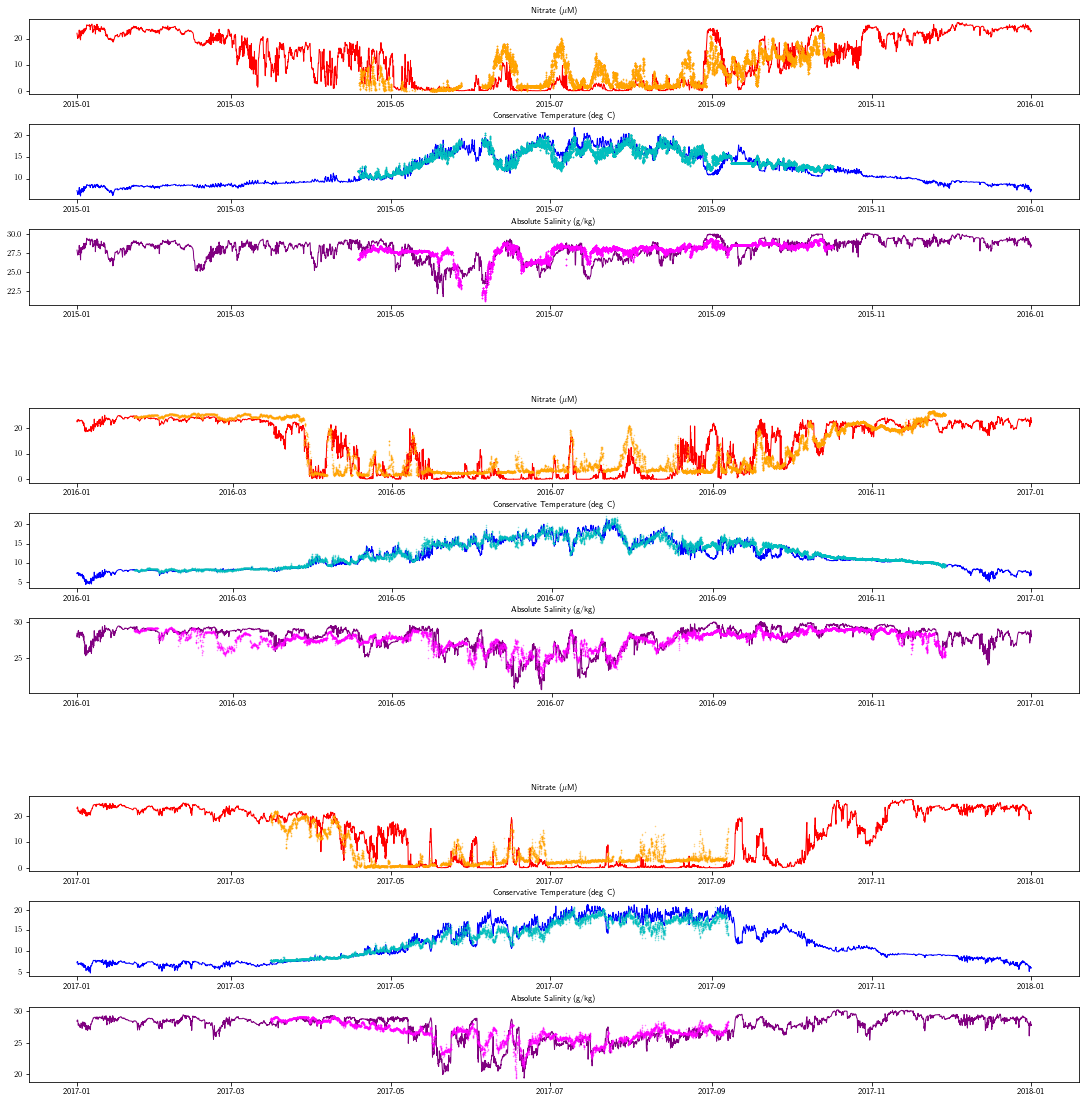

In [19]:
fig = plt.figure(figsize = (18,18))
gsv = gridspec.GridSpec(3,1,left=.11,right=.92,hspace=.36,bottom=.12,top=.94,height_ratios=[1,1,1])
gs15=gridspec.GridSpecFromSubplotSpec(3,1,subplot_spec=gsv[0],wspace=.3,hspace=.4,height_ratios=[1,1,1])
gs16=gridspec.GridSpecFromSubplotSpec(3,1,subplot_spec=gsv[1],wspace=.3,hspace=.4,height_ratios=[1,1,1])
gs17=gridspec.GridSpecFromSubplotSpec(3,1,subplot_spec=gsv[2],wspace=.3,hspace=.4,height_ratios=[1,1,1])
ax=dict()
for iyr in (2015,2016,2017):
    ax[iyr]=dict()
            
ax[2015]['nit']=fig.add_subplot(gs15[0,0])
ax[2016]['nit']=fig.add_subplot(gs16[0,0])
ax[2017]['nit']=fig.add_subplot(gs17[0,0])
ax[2015]['phys']=fig.add_subplot(gs15[1,0])
ax[2016]['phys']=fig.add_subplot(gs16[1,0])
ax[2017]['phys']=fig.add_subplot(gs17[1,0])
ax[2015]['sal']=fig.add_subplot(gs15[2,0])
ax[2016]['sal']=fig.add_subplot(gs16[2,0])
ax[2017]['sal']=fig.add_subplot(gs17[2,0])

aalpha=.5
lwid=.5
dateFmt = mdates.DateFormatter('%b')
for iyr in (2015,2016,2017):
    iiiSS=(py_times>=tlim[iyr][0])&(py_times<=tlim[iyr][1])
    pS3modN,=ax[iyr]['nit'].plot(times[iyr],np.mean(ff[iyr].variables['nitrate'][:,0:2,0,0],1),'-',alpha=1,color='red',lw=1,label='model')
    pSSN,=ax[iyr]['nit'].plot(data.loc[iiiSS,['dtUTC']],data.loc[iiiSS,['N']],'.',alpha=aalpha,color='orange',markersize=1,label='obs')
    ax[iyr]['nit'].set_title('Nitrate ($\mu$M)')
    pS3S,=ax[iyr]['phys'].plot(times[iyr],np.mean(ffp[iyr].variables['votemper'][:,0:2,0,0],1),'-',alpha=1,color='blue',lw=1,label='model')
    pSSN,=ax[iyr]['phys'].plot(data.loc[iiiSS,['dtUTC']],data.loc[iiiSS,['CT']],'.',alpha=aalpha,color='c',markersize=1,label='obs')
    ax[iyr]['phys'].set_title('Conservative Temperature (deg C)')
    pS3S,=ax[iyr]['sal'].plot(times[iyr],np.mean(ffp[iyr].variables['vosaline'][:,0:2,0,0],1),'-',alpha=1,color='purple',lw=1,label='model')
    pSSN,=ax[iyr]['sal'].plot(data.loc[iiiSS,['dtUTC']],data.loc[iiiSS,['SA']],'.',alpha=aalpha,color='fuchsia',markersize=1,label='obs')
    ax[iyr]['sal'].set_title('Absolute Salinity (g/kg)')
    #pS3T,=ax[iyr]['phys'].plot(times[iyr],np.mean(ffp[iyr].variables['vosaline'][:,0:2,0,0],1),'-',alpha=1,color='blue',lw=1)
    #pSSN,=ax[iyr]['phys'].plot(data.loc[iiiSS,['dtUTC']],data.loc[iiiSS,['SA']],'.',alpha=aalpha,color='cyan',markersize=1)
    

In [20]:
np.shape(data.loc[ii,['mod_nitrate']].values[:,0])

(8037,)

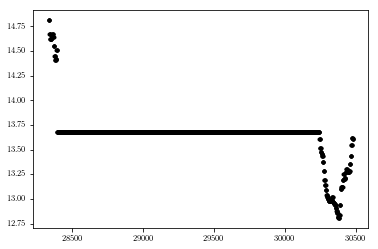

In [21]:
ij=(data['dtUTC']>dt.datetime(2015,9,8))&(data['dtUTC']<dt.datetime(2015,9,17))
plt.plot(data.loc[ij,['CT']],'k.')

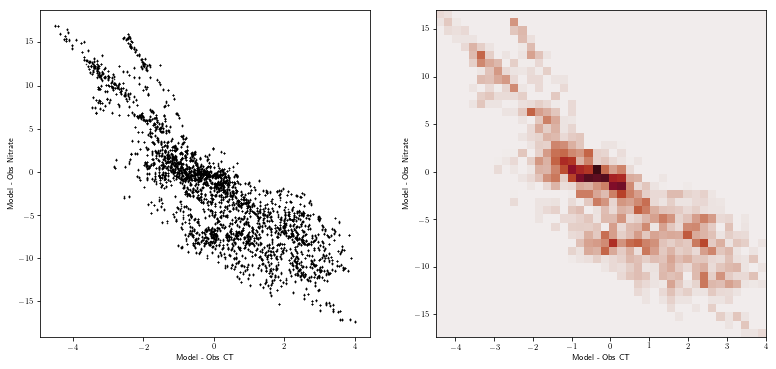

In [22]:
# plot temperature bias versus nitrate bias for June 1 to Oct 1 2015:
fig,ax=plt.subplots(1,2,figsize=(13,6))

ii15=(~ij)&(data['dtUTC']>dt.datetime(2015,6,1))&(data['dtUTC']<dt.datetime(2015,10,1))&(~np.isnan(data['CT']))\
    &(~np.isnan(data['N']))&(~np.isnan(data['mod_nitrate']))&(~np.isnan(data['mod_votemper']))&(data['mod_nitrate']>1);
ii16=(~ij)&(data['dtUTC']>dt.datetime(2016,6,1))&(data['dtUTC']<dt.datetime(2016,10,1))&(~np.isnan(data['CT']))\
    &(~np.isnan(data['N']))&(~np.isnan(data['mod_nitrate']))&(~np.isnan(data['mod_votemper']))&(data['mod_nitrate']>1);
ii17=(~ij)&(data['dtUTC']>dt.datetime(2017,6,1))&(data['dtUTC']<dt.datetime(2017,9,1))&(~np.isnan(data['CT']))\
    &(~np.isnan(data['N']))&(~np.isnan(data['mod_nitrate']))&(~np.isnan(data['mod_votemper']))&(data['mod_nitrate']>1);

iax=ax[0]
iax.plot(np.array(data.loc[ii,['mod_votemper']].values).flatten()-np.array(data.loc[ii,['CT']].values).flatten(),
         np.array(data.loc[ii,['mod_nitrate']].values).flatten()-np.array(data.loc[ii,['N']].values).flatten(),'k.',ms=1);
iax.set_ylabel('Model - Obs Nitrate')
iax.set_xlabel('Model - Obs CT')
iax=ax[1]
iax.hist2d(np.array(data.loc[ii,['mod_votemper']].values).flatten()-np.array(data.loc[ii,['CT']].values).flatten(),
           np.array(data.loc[ii,['mod_nitrate']].values).flatten()-np.array(data.loc[ii,['N']].values).flatten(),40,cmap=cmocean.cm.amp);
iax.set_ylabel('Model - Obs Nitrate')
iax.set_xlabel('Model - Obs CT')
#ax.plot(data.loc[ii,['mod_vosaline']])
#ax.plot(data.loc[ii,['SA']])

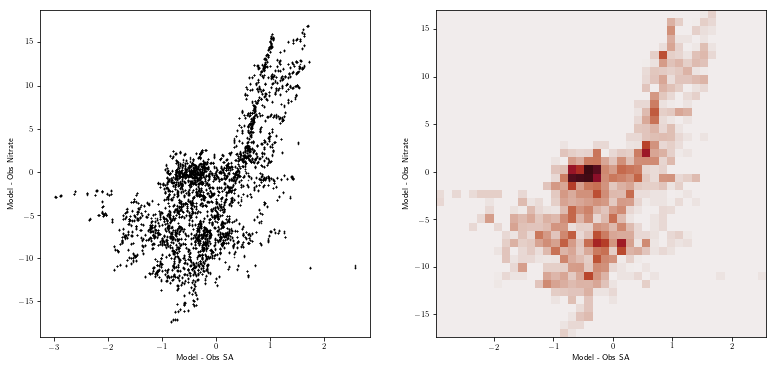

In [26]:
# plot SA bias versus nitrate bias for June 1 to Oct 1 2015:
fig,ax=plt.subplots(1,2,figsize=(13,6))

ii=(~ij)&(data['dtUTC']>dt.datetime(2015,6,1))&(data['dtUTC']<dt.datetime(2015,10,1))&(~np.isnan(data['SA']))\
    &(~np.isnan(data['N']))&(~np.isnan(data['mod_nitrate']))&(~np.isnan(data['mod_vosaline']))&(data['mod_nitrate']>1);

iax=ax[0]
iax.plot(np.array(data.loc[ii,['mod_vosaline']].values).flatten()-np.array(data.loc[ii,['SA']].values).flatten(),
         np.array(data.loc[ii,['mod_nitrate']].values).flatten()-np.array(data.loc[ii,['N']].values).flatten(),'k.',ms=1);
iax.set_ylabel('Model - Obs Nitrate')
iax.set_xlabel('Model - Obs SA')
iax=ax[1]
iax.hist2d(np.array(data.loc[ii,['mod_vosaline']].values).flatten()-np.array(data.loc[ii,['SA']].values).flatten(),
           np.array(data.loc[ii,['mod_nitrate']].values).flatten()-np.array(data.loc[ii,['N']].values).flatten(),40,cmap=cmocean.cm.amp);
iax.set_ylabel('Model - Obs Nitrate')
iax.set_xlabel('Model - Obs SA')
#ax.plot(data.loc[ii,['mod_vosaline']])
#ax.plot(data.loc[ii,['SA']])

In [38]:
[(ii-jj) for ii,jj in zip(data['dtUTC'][1:11],data['dtUTC'][0:10])]

[Timedelta('0 days 00:00:01.999999'),
 Timedelta('0 days 00:00:01.000005'),
 Timedelta('0 days 00:29:56.999999'),
 Timedelta('0 days 00:00:02'),
 Timedelta('0 days 00:00:00.999994'),
 Timedelta('0 days 00:29:57'),
 Timedelta('0 days 00:00:01.999999'),
 Timedelta('0 days 00:00:01.000005'),
 Timedelta('0 days 00:29:56.999999'),
 Timedelta('0 days 00:00:01.999999')]

In [29]:
data['dtUTC'][0:10]

0   2015-04-18 08:00:21.000000
1   2015-04-18 08:00:22.999999
2   2015-04-18 08:00:24.000004
3   2015-04-18 08:30:21.000003
4   2015-04-18 08:30:23.000003
5   2015-04-18 08:30:23.999997
6   2015-04-18 09:00:20.999997
7   2015-04-18 09:00:22.999996
8   2015-04-18 09:00:24.000001
9   2015-04-18 09:30:21.000000
Name: dtUTC, dtype: datetime64[ns]

In [30]:
data['dtUTC'][1]-data['dtUTC'][0]

Timedelta('0 days 00:00:01.999999')

### Direct Model-data comparisons

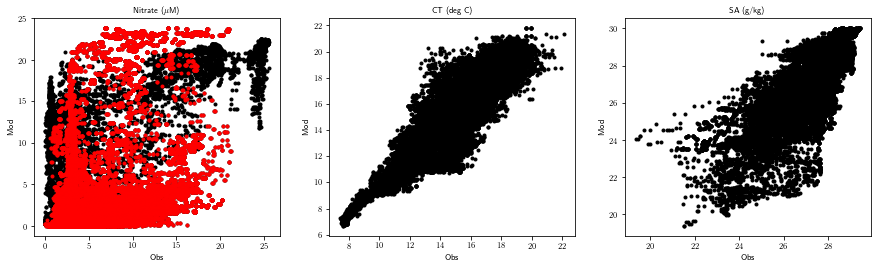

In [48]:
fig,ax=plt.subplots(1,3,figsize=(15,4))
iax=ax[0]
iax.plot(data['N'],data['mod_nitrate'],'k.')
isummer=(data['dtUTC'].dt.month>5)&(data['dtUTC'].dt.month<10)
iax.plot(data.loc[isummer,['N']],data.loc[isummer,['mod_nitrate']],'r.')
iax.set_title('Nitrate ($\mu$M)')
iax.set_xlabel('Obs')
iax.set_ylabel('Mod')
iax=ax[1]
iax.plot(data['CT'],data['mod_votemper'],'k.')
iax.set_title('CT (deg C)')
iax.set_xlabel('Obs')
iax.set_ylabel('Mod')
iax=ax[2]
iax.plot(data['SA'],data['mod_vosaline'],'k.')
iax.set_title('SA (g/kg)')
iax.set_xlabel('Obs')
iax.set_ylabel('Mod')

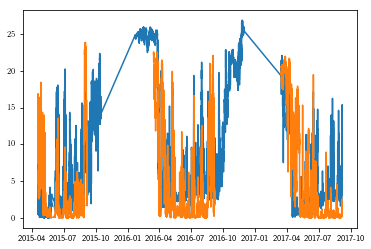

In [358]:
plt.plot(data['dtUTC'],data['N'])
plt.plot(data['dtUTC'],data['mod_nitrate'])

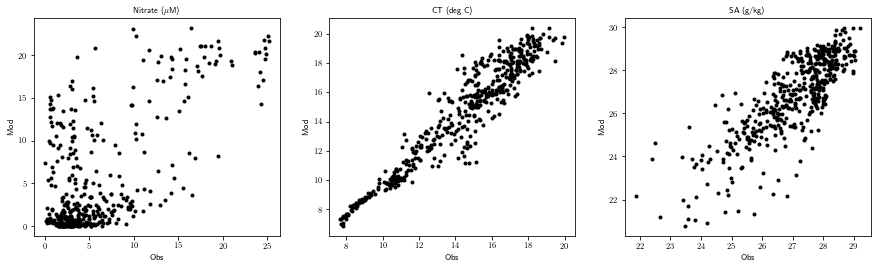

In [365]:
### daily means
days=np.array([(ii-dt.datetime(2016,1,1)).total_seconds()/(24*3600) for ii in data['dtUTC']])
gd=data.groupby(np.floor(days))
fig,ax=plt.subplots(1,3,figsize=(15,4))
iax=ax[0]
iax.plot(gd['N'].mean(),gd['mod_nitrate'].mean(),'k.')
iax.set_title('Nitrate ($\mu$M)')
iax.set_xlabel('Obs')
iax.set_ylabel('Mod')
iax=ax[1]
iax.plot(gd['CT'].mean(),gd['mod_votemper'].mean(),'k.')
iax.set_title('CT (deg C)')
iax.set_xlabel('Obs')
iax.set_ylabel('Mod')
iax=ax[2]
iax.plot(gd['SA'].mean(),gd['mod_vosaline'].mean(),'k.')
iax.set_title('SA (g/kg)')
iax.set_xlabel('Obs')
iax.set_ylabel('Mod')

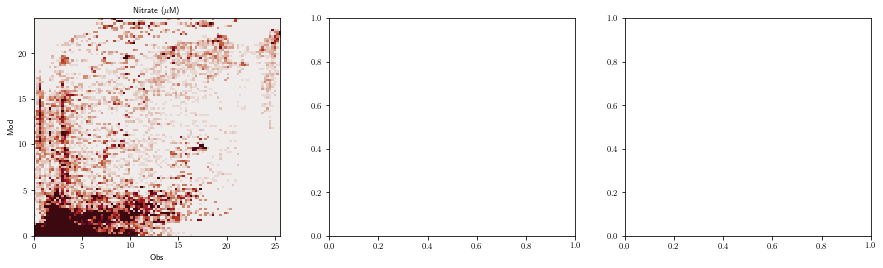

In [352]:
fig,ax=plt.subplots(1,3,figsize=(15,4))
iax=ax[0]
data2=data.loc[~np.isnan(data['N'])&~np.isnan(data['mod_nitrate'])]
iax.hist2d(data2['N'],data2['mod_nitrate'],100,cmap=cmocean.cm.amp,vmin=0,vmax=15);
iax.set_title('Nitrate ($\mu$M)')
iax.set_xlabel('Obs')
iax.set_ylabel('Mod')

# compare with nearby obs:

In [67]:
dfPSF=et.loadPSF()
dfPSF.head()

,Lat,Lon,NO23,PO4,Si,Station,Z,dtUTC,Chl,Depth_m,Phaeo
0,49.608333,-124.866667,18.65,1.459,68.43,BS1,2.0,2015-02-18 23:07:00,NaN,NaN,NaN
1,49.608333,-124.866667,26.62,2.175,55.73,BS1,20.0,2015-02-18 23:07:00,NaN,NaN,NaN
2,49.608333,-124.866667,16.25,1.809,39.14,BS1,2.0,2015-03-21 22:55:00,NaN,NaN,NaN
3,49.608333,-124.866667,16.83,2.069,39.11,BS1,20.0,2015-03-21 22:55:00,NaN,NaN,NaN
4,49.608333,-124.866667,24.27,0.551,49.90,BS1,20.0,2015-04-05 23:10:00,NaN,NaN,NaN


In [68]:
dfH=et.loadHakai()
dfH.head()

Note: CTD depths (pZ) may vary from bottle depths (Z) by up to  1.5  m.


,NO2+NO3 (uM),PO4,SiO2,dtUTC,Station,Lat,Lon,Z,SA,CT,pZ
0,17.528459,1.480,37.597988,2014-11-07 19:30:39,QU5,50.1183,-125.2122,0.0,26.161950,11.063901,0.977
1,19.534208,1.637,39.536296,2014-11-07 18:30:30,QU17,50.1200,-125.1300,0.0,26.653561,10.967601,0.959
2,20.243301,1.671,38.212329,2014-11-07 17:30:32,QU24,50.0300,-125.0800,0.0,27.444017,11.171578,0.940
3,19.414687,1.621,38.879558,2014-11-07 19:30:39,QU5,50.1183,-125.2122,5.0,27.139286,11.176216,4.860
4,19.728054,1.646,39.173135,2014-11-07 18:30:30,QU17,50.1200,-125.1300,5.0,26.902988,10.976844,4.895


In [86]:
dfPSFSS=dfPSF.loc[(np.abs(dfPSF.Lon-sslon)<.15)&(np.abs(dfPSF.Lat-sslat)<.15)&(dfPSF.Z<2)]

In [87]:
dfHSS=dfH.loc[(np.abs(dfH.Lon-sslon)<.15)&(np.abs(dfH.Lat-sslat)<.15)&(dfH.Z<2)]

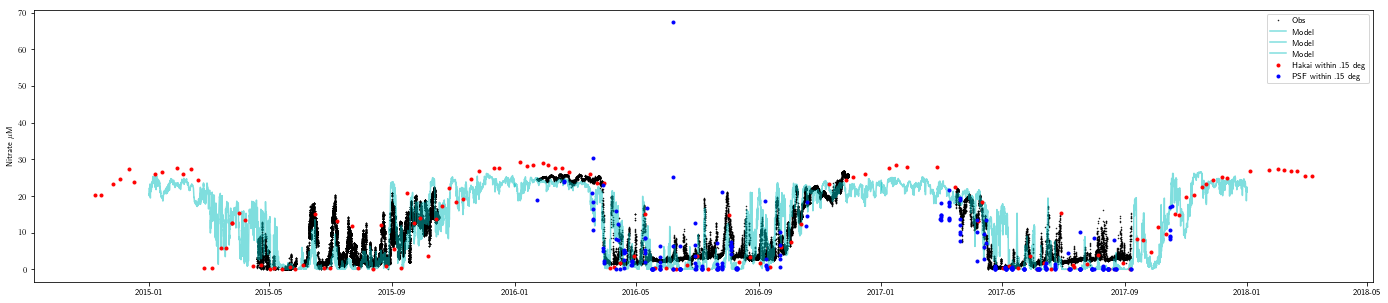

In [97]:
fig,ax=plt.subplots(1,1,figsize=(24,5))
ax.plot(data['dtUTC'],data['N'],'k.',ms=1,label='Obs')
for iyr in (2015,2016,2017):
    ax.plot(times[iyr],np.mean(ff[iyr].variables['nitrate'][:,:2,0,0],1),'c-',alpha=.5,label='Model')
ax.plot(dfHSS['dtUTC'],dfHSS['NO2+NO3 (uM)'],'.',color='red',label='Hakai within .15 deg')
ax.plot(dfPSFSS['dtUTC'],dfPSFSS['NO23'],'b.',label='PSF within .15 deg')
ax.legend()
ax.set_ylabel('Nitrate $\mu$M')

# attempt correction: 

In [178]:
days=np.array([(ii-dt.datetime(2016,1,1)).total_seconds()/(24*3600) for ii in data['dtUTC']])

In [180]:
Norig=np.array(data['N'])

In [183]:
daysObs=np.array([(ii-dt.datetime(2016,1,1)).total_seconds()/(24*3600) for ii in dfHSS['dtUTC']]+[(ii-dt.datetime(2016,1,1)).total_seconds()/(24*3600) for ii in dfPSFSS['dtUTC']])

In [190]:
Nobs=np.concatenate((dfHSS['NO2+NO3 (uM)'].values,dfPSFSS['NO23'].values))

In [202]:
ii=~np.isnan(Nobs)
Nobs=Nobs[ii]
daysObs=daysObs[ii]

In [203]:
np.shape(daysObs),np.shape(Nobs)

((370,), (370,))

In [325]:
Nout=np.nan*np.ones(np.shape(Norig))
Nout2=np.nan*np.ones(np.shape(Norig))
Nout3=np.nan*np.ones(np.shape(Norig))

In [326]:
window=3
for ii in range(0,len(Norig)):
    # get input N and obs N within window:
    iorigN=Norig[(np.abs(days-days[ii])<window)&(Norig<5)]
    iobsN=Nobs[(np.abs(daysObs-days[ii])<window)&(Nobs<5)]
    if (len(iorigN))>0 and len(iobsN)>0:
        Nout[ii]=Norig[ii]+np.mean(iobsN)-np.nanmean(iorigN)
        Nout2[ii]=Norig[ii]+np.min(iobsN)-np.nanmin(iorigN)
        Nout3[ii]=Norig[ii]+np.median(iobsN)-np.nanmedian(iorigN)

/home/eolson/anaconda3/envs/python36/lib/python3.6/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in less


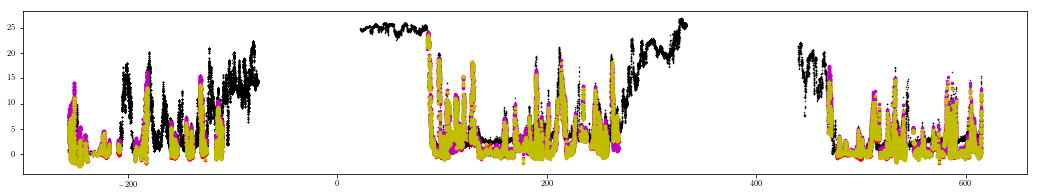

In [327]:

fig,ax=plt.subplots(1,1,figsize=(18,3))
ax.plot(days,Norig,'k.',ms=1)
ax.plot(days,Nout,'r.',ms=5)
ax.plot(days,Nout2,'m.',ms=5)
ax.plot(days,Nout3,'y.',ms=5)

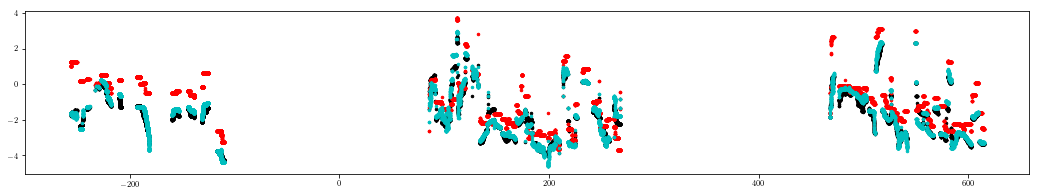

In [328]:
fig,ax=plt.subplots(1,1,figsize=(18,3))
ax.plot(days,Nout-Norig,'k.',ms=5)
ax.plot(days,Nout2-Norig,'r.',ms=5)
ax.plot(days,Nout3-Norig,'c.',ms=5)

In [329]:
ii2016=(days>0)&(days<300)
iinan=~np.isnan(Nout3)
p16=np.polyfit(days[ii2016&iinan],Nout2[ii2016&iinan]-Norig[ii2016&iinan],1)

In [330]:
ii2017=(days>400)&(days<650)
iinan=~np.isnan(Nout3)
p17=np.polyfit(days[ii2017&iinan],Nout2[ii2017&iinan]-Norig[ii2017&iinan],1)

In [331]:
p16

array([-0.00700749, -0.19159388])

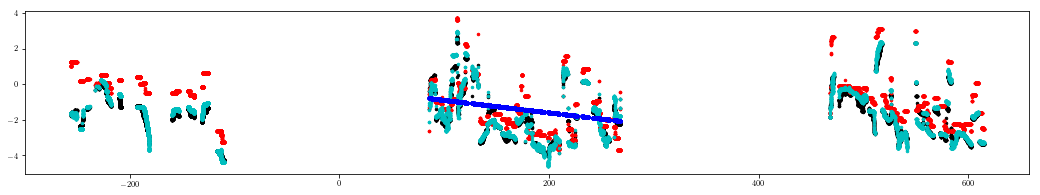

In [332]:
fig,ax=plt.subplots(1,1,figsize=(18,3))
ax.plot(days,Nout-Norig,'k.',ms=5)
ax.plot(days,Nout2-Norig,'r.',ms=5)
ax.plot(days,Nout3-Norig,'c.',ms=5)
ax.plot(days[ii2016&iinan],p16[0]*days[ii2016&iinan]+p16[1],'b.')

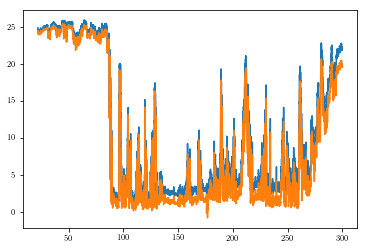

In [333]:
plt.plot(days[ii2016],Norig[ii2016])
plt.plot(days[ii2016],Norig[ii2016]+p16[0]*days[ii2016]+p16[1])

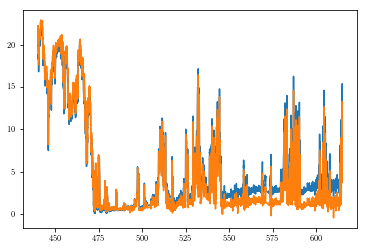

In [334]:
plt.plot(days[ii2017],Norig[ii2017])
plt.plot(days[ii2017],Norig[ii2017]+p17[0]*days[ii2017]+p17[1])

In [335]:
data['cor']=data['N']
data.loc[ii2016,['cor']]=Norig[ii2016]+p16[0]*days[ii2016]+p16[1]
data.loc[ii2017,['cor']]=Norig[ii2017]+p17[0]*days[ii2017]+p17[1]

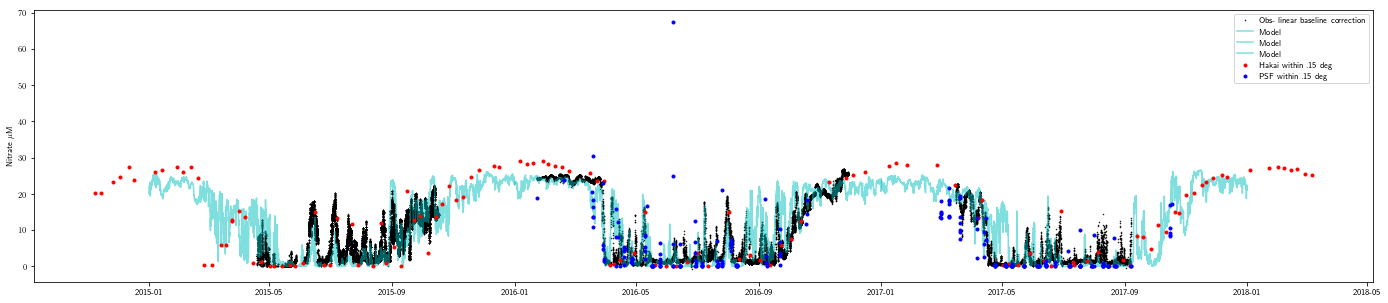

In [336]:
fig,ax=plt.subplots(1,1,figsize=(24,5))
ax.plot(data['dtUTC'],data['cor'],'k.',ms=1,label='Obs- linear baseline correction')
for iyr in (2015,2016,2017):
    ax.plot(times[iyr],np.mean(ff[iyr].variables['nitrate'][:,:2,0,0],1),'c-',alpha=.5,label='Model')
ax.plot(dfHSS['dtUTC'],dfHSS['NO2+NO3 (uM)'],'.',color='red',label='Hakai within .15 deg')
ax.plot(dfPSFSS['dtUTC'],dfPSFSS['NO23'],'b.',label='PSF within .15 deg')
ax.legend()
ax.set_ylabel('Nitrate $\mu$M')

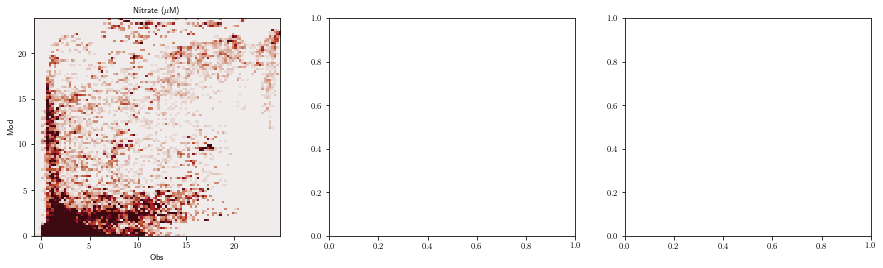

In [353]:
fig,ax=plt.subplots(1,3,figsize=(15,4))
iax=ax[0]
data2=data.loc[~np.isnan(data['N'])&~np.isnan(data['mod_nitrate'])]
iax.hist2d(data2['cor'],data2['mod_nitrate'],100,cmap=cmocean.cm.amp,vmin=0,vmax=15);
iax.set_title('Nitrate ($\mu$M)')
iax.set_xlabel('Obs')
iax.set_ylabel('Mod')